# Information Value (IV) and Weight of Evidence (WOE) in Python

Information value (IV) and weight of evidence (WOE) are simple and powerful techniques of conducting attribute relevance analysis. They provide a great framework for exploratory analysis and have been used extensively in the credit risk world for several decades.

This simple module enables quick attribute relevance analysis: calculation of IV and WOE, creation of readable visualizations and evaluation of statistical significance and effect size.

- In order to see how it can be used in practice, check [**Telco Customer Churn Analysis**](https://github.com/klaudia-nazarko/iv-and-woe-python/blob/master/telco_customer_churn_analysis.ipynb).
- What about statistical significance? Check [**Information Value vs Statistical Significance Analysis**](https://github.com/klaudia-nazarko/iv-and-woe-python/blob/master/statistical_significance_of_information_value.ipynb).

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv('datagen.csv', na_values=[' '])

In [4]:
df['label'] = df['app_status'].map({'valid': 0, 'invalid': 1})
df['browserType'] = df['browser'].map({0: 'edge', 1: 'chrome', 2: 'safari', 3: 'firefox', 4: 'opera', 5: 'vivaldi' })

df.drop(['app_id', 'app_status', 'browser', 'score'], axis=1, inplace=True)

In [5]:
df.sample(5)

,ipAddress,ipHop,timeSubmitSec,package,inList,inCust,weekDay,appHour,label,browserType
4444,"12,307.00",1.00,17.00,6.00,0.00,1,3.00,10.00,0,safari
473,"9,230.00",0.00,21.00,0.00,0.00,0,5.00,13.00,0,opera
7650,"12,307.00",0.00,22.00,0.00,1.00,0,2.00,11.00,0,edge
9282,"11,818.00",3.00,2.00,12.00,3.00,1,4.00,1.00,1,opera
5951,"18,461.00",1.00,20.00,3.00,0.00,1,3.00,10.00,0,edge


## Create Feature Objects

Basic object in IV & WOE analysis is a single feature. There are two types of features: categorical and continuous.

Create feature objects by instantiating CategoricalFeature and ContinuousFeature class.

**CategoricalFeature(df, colname)**

Creates a feature object.
* df - DataFrame with data
* colname - name of the column containing a feature

Attributes and methods:
* feature - returns name of a column
* df - returns a dataframe
* df_lite - returns a new dataframe limited to bin and label

**ContinuousFeature(df, colname)**

Creates a feature object. Groups continuous values into bins.
* df - DataFrame with data
* colname - name of the column containing a feature

Attributes and methods:
* feature - returns name of a column
* df - returns a dataframe
* df_lite - returns a new dataframe limited to bin and label

In [6]:
feat_browserType = CategoricalFeature(df, 'browserType')
feat_appHour = ContinuousFeature(df, 'appHour')

In [9]:
feat_browserType.df_lite.sample(5)

,bin,label
4868,chrome,0
1868,firefox,0
6163,chrome,0
6412,edge,0
3731,chrome,0


Create a list of features that will be analyzed. It can be done manually or dynamically, as below:

In [10]:
feats_manual = [feat_browserType, feat_appHour]

In [11]:
feats_dict = {}

for col in [c for c in df.columns if c != 'label']:
    if is_numeric_dtype(df[col]):
        feats_dict[col] = ContinuousFeature(df, col)
    else:
        feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

## Information Value Class

**IV()**

Attributes and methods:
- group_by_feature(feature) - returns a dataframe with number of observations in each bin and count of good and bad
- calculate_iv(feature) - returns a dataframe (with calculation of WOE and IV) and IV for a single feature
- draw_woe(feature) - draws a chart with visualization of WOE values for a single feature
- interpretation(iv_value) - returns the predictive power based on input IV
- interpret_iv(feature) - returns the predictive power based on IV of a single feature
- print_iv(feature) - prints interpretation of IV of a single feature

In [12]:
iv = IV()

In [13]:
iv.group_by_feature(feat_appHour)

,appHour,count,good,bad
0,1.00,5811,311,5500
1,11.00,4189,1689,2500


In [14]:
iv_df, iv_value = iv.calculate_iv(feat_appHour)
display(iv_df)
print('Information value: ', iv_value)

,appHour,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,1.00,5811,311,5500,0.16,0.69,-0.53,-1.49,0.79
1,11.00,4189,1689,2500,0.84,0.31,0.53,0.99,0.53


Information value:  1.319655986176189


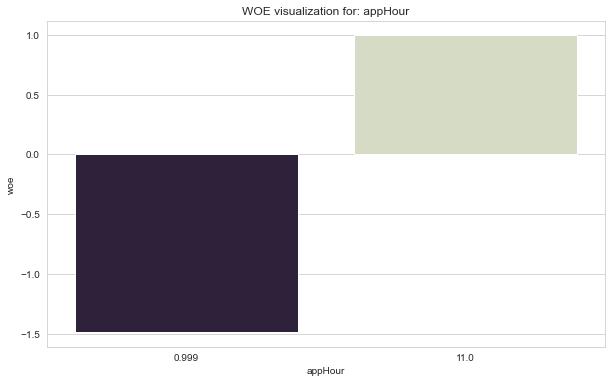

In [15]:
iv.draw_woe(feat_appHour)

In [17]:
print('%s is a %s predictor.' % (feat_appHour.feature.capitalize(), iv.interpret_iv(feat_appHour)))
print('A feature with IV = 0.2 is a %s predictor.' % iv.interpretation(0.2))
print()
iv.print_iv(feat_appHour)

Apphour is a suspicious predictor.
A feature with IV = 0.2 is a medium predictor.

Information value: 1.32
Apphour is a suspicious predictor


## Statistical Significance Class

**StatsSignificance()**

Attributes and methods:
- group_by_feature(feature) - returns a dataframe with number of observations in each bin and count of good and bad
- calculate_chi(feature) - returns p-value and effect size (Cramer's V) for a single feature
- interpretation(effect_size) - returns the predictive power based on input effect size
- interpret_iv(feature) - returns the predictive power based on effect size of a single feature
- print_iv(feature) - prints interpretation of p-value and effect size of a single feature

In [18]:
s = StatsSignificance()

In [19]:
p_value, effect_size = s.calculate_chi(feat_appHour)
print('p-value: %0.2f' % p_value)
print('effect size: %0.2f' % effect_size)

p-value: 0.00
effect size: 0.43


In [20]:
print('%s is a %s predictor.' % (feat_appHour.feature.capitalize(), s.interpret_chi(feat_appHour)))
print('A feature with effect size = 0.2 is a %s predictor.' % s.interpretation(0.2))
print()
s.print_chi(feat_appHour)

Apphour is a strong predictor.
A feature with effect size = 0.2 is a medium predictor.

P-value: 0.00
Effect size: 0.43
Apphour is a strong predictor


## Attribute Relevance Class

**AttributeRelevance()**

Attributes and methods:
- bulk_iv(features_list, iv, woe_extremes=False) - returns IV for features from the list; optionally: returns min and max WOE
- bulk_stats(features_list, s) - returns p-value and effect size for features from the list
- analyze(features_list, iv, s=None, interpretation=False) - returns IV (and p-value and effect size) for features from the list; optionally: returns interpretation of predictive power based on IV and effect size

In [21]:
ar = AttributeRelevance()

In [22]:
ar.bulk_iv(feats, iv).head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv
ipAddress,0.37
ipHop,0.00
timeSubmitSec,0.36
package,3.52
inList,4.33


In [23]:
ar.bulk_iv(feats, iv, woe_extremes=True).head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,woe_min,woe_max
ipAddress,0.37,0.00,0.98
ipHop,0.00,0.00,0.00
timeSubmitSec,0.36,0.00,0.70
package,3.52,-3.82,1.91
inList,4.33,-2.03,3.58


In [24]:
ar.bulk_stats(feats, s).head()

,p-value,effect_size
ipAddress,0.00,0.41
ipHop,1.00,0.00
timeSubmitSec,0.00,0.41
package,0.00,0.62
inList,0.00,0.82


In [25]:
ar.analyze(feats, iv).head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv
inList,4.33
browserType,3.58
bin,3.58
package,3.52
appHour,1.32


In [26]:
ar.analyze(feats, iv, s).head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size
inList,4.33,0.00,0.82
browserType,3.58,0.00,0.68
bin,3.58,0.00,0.68
package,3.52,0.00,0.62
appHour,1.32,0.00,0.43


In [27]:
ar.analyze(feats, iv, s, interpretation=True).head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size,iv_interpretation,es_interpretation
inList,4.33,0.00,0.82,suspicious,very strong
browserType,3.58,0.00,0.68,suspicious,very strong
bin,3.58,0.00,0.68,suspicious,very strong
package,3.52,0.00,0.62,suspicious,very strong
appHour,1.32,0.00,0.43,suspicious,strong


## Visualizations of Information Value

**IV()**

Attributes and methods:
- draw_iv(features_list, iv) - draws a chart with visualization of IV of features from the list
- draw extremes(features_list, iv) - draws a chart with visualization of min and max WOE of features from the list
- draw multiplot(features_list, iv) - draws a multi-chart with visualization of WOE of features from the list

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


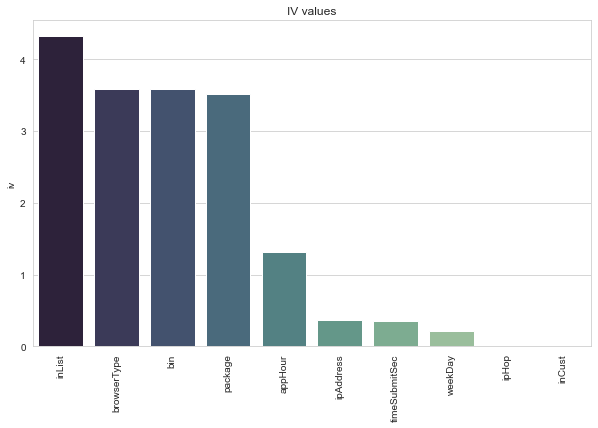

In [28]:
ar.draw_iv(feats, iv)

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


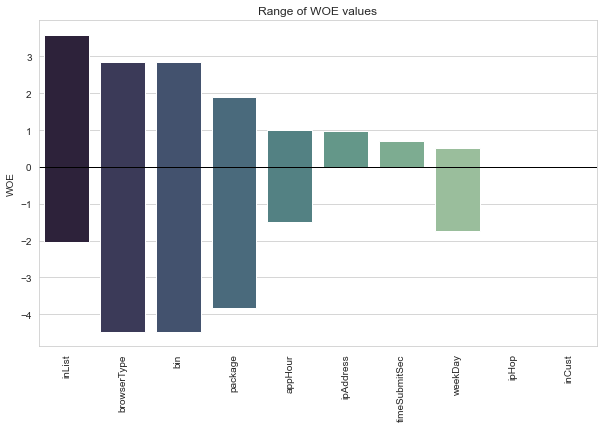

In [29]:
ar.draw_woe_extremes(feats, iv)

D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


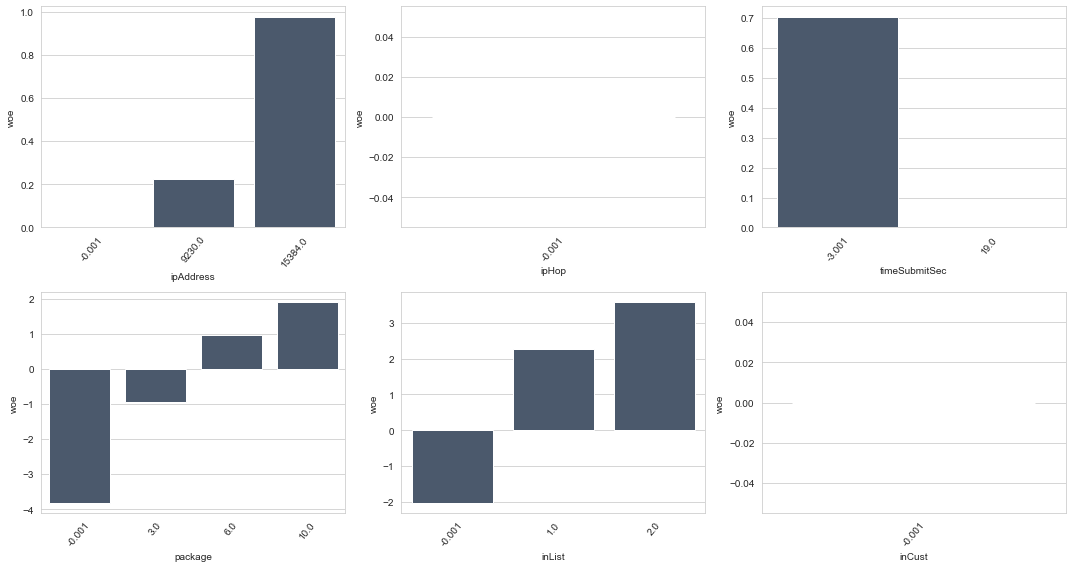

In [30]:
ar.draw_woe_multiplot(feats[:6], iv)

### Grouping continuous values into bins

Values in continuous features are grouped according to the following rules:
- Each bin should have at least 5% of the observations.
- Each bin should be non-zero for both non-events and events.
- The WOE should be monotonic, i.e. either growing or decreasing with the groupings.
- Missing values are binned separately.

### Reference

1. https://stats.stackexchange.com/questions/93170/why-do-we-calculate-information-value
2. https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-
3. https://towardsdatascience.com/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04
4. https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv
5. https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb
6. https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/